In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('../data/input_table/pre_dataset.csv')
data = data.sample(frac=1, random_state=42, ignore_index=True)

In [3]:
data.station.nunique()

100

In [4]:
data['t+6'].mean()

0.18105744520030234

In [5]:

data.head()

,t-11,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t0,station,sin_time,cos_time,dow,weekend,t+6
0,0,0,0,0,0,1,1,1,1,1,1,0,16,-0.173648,-0.984808,4,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,28,-0.258819,0.965926,2,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,86,0.991445,0.130526,5,1,0
3,1,1,1,1,0,0,0,0,0,0,0,0,72,-0.953717,-0.300706,2,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,9,0.300706,0.953717,6,1,0


In [6]:
data.shape

(1323000, 18)

In [7]:
TRAIN_NUM = 1_000_000
train_data = data.iloc[:TRAIN_NUM]
valid_data = data.iloc[TRAIN_NUM:]
len(train_data), len(valid_data)

(1000000, 323000)

In [8]:
# feature definition
general_features = [col for col in data.columns if col not in ['station', 't+6']]
embedding_features = ['station']
target_features = ['t+6']

In [9]:
train_data[general_features].values.shape

(1000000, 16)

## Dataset 정의

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader

class EvcBaseDataset(Dataset):
    def __init__(self, xs, ys):
        assert len(xs) == len(ys)

        self.xs = torch.tensor(xs).float()
        self.ys = torch.tensor(ys).float()

    def __len__(self):
        return len(self.xs)

    def __getitem__(self, i):
        x, y = self.xs[i], self.ys[i]
        return x, y


class EvcEmbeddingDataset(EvcBaseDataset):
    def __init__(self, xs, es, ys):
        assert len(xs) == len(ys)

        self.xs = torch.tensor(xs).float()
        self.es = torch.tensor(es)
        self.ys = torch.tensor(ys).float()
        
    def __len__(self):
        return len(self.xs)

    def __getitem__(self, i):
        x, e, y = self.xs[i], self.es[i], self.ys[i]
        return x, e, y

In [11]:
import torch
from torch.utils.data import Dataset, DataLoader


class EvcDataset(Dataset):
    def __init__(self, xs, sids, ys):
        assert len(xs) == len(ys)

        self.xs = torch.tensor(xs).float()
        self.sids = torch.tensor(sids)
        self.ys = torch.tensor(ys).float()
        
    def __len__(self):
        return len(self.xs)

    def __getitem__(self, i):
        x, sid, y = self.xs[i], self.sids[i], self.ys[i]
        return x, sid, y

In [12]:
trainset = EvcDataset(xs=train_data[general_features].values,
                      sids=train_data[embedding_features].values.flatten(),
                      ys=train_data[target_features].values)
validset = EvcDataset(xs=valid_data[general_features].values,
                      sids=valid_data[embedding_features].values.flatten(),
                      ys=valid_data[target_features].values)    

In [13]:
train_loader = DataLoader(trainset, batch_size=256)
valid_loader = DataLoader(validset, batch_size=1024)

## 모델 정의

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BaseMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.require_sid = False
        self.fc1 = nn.Linear(16, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return torch.sigmoid(x)


class BaseEmbeddingMLP(nn.Module):
    def __init__(self, station_size, n_dim):
        super().__init__()
        self.require_sid = True
        self.embedding = nn.Embedding(num_embeddings=station_size, embedding_dim=n_dim)
        self.fc1 = nn.Linear(16+n_dim, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x, e):
        e = self.embedding(e)
        x = torch.cat((x, e), dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return torch.sigmoid(x)

## Train, Test function

In [27]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

def train(model, train_dataloader, optim, epoch):
    model.train()
    criterion = nn.BCELoss()
    for b_i, (X, E, y) in enumerate(train_dataloader):
        optim.zero_grad()

        if model.require_sid:
            prob_pred = model(X,E)
        else:
            prob_pred = model(X)
        
        loss = criterion(prob_pred, y)
        loss.backward()
        optim.step()
        
        if b_i % 1000 == 0:
            print('epoch: {} [{}/{} ({:.0f}%)]\t training loss: {:.6f}'.format(
                epoch, b_i * len(X), len(train_dataloader.dataset),
                100 * b_i / len(train_dataloader), loss.item()
            ))


def test(model, test_dataloader):
    model.eval()
    criterion = nn.BCELoss(reduction='sum')
    loss = 0

    with torch.no_grad():
        prob_pred_total = torch.Tensor()
        y_total = torch.Tensor()

        for X, E, y in test_dataloader:
            if model.require_sid:
                prob_pred = model(X,E)
            else:
                prob_pred = model(X)
            prob_pred_total = torch.cat([prob_pred_total, prob_pred.flatten()], dim=0)
            y_total = torch.cat([y_total, y.flatten()], dim=0)

            loss += criterion(prob_pred, y).item()
    loss /= len(test_dataloader.dataset)

    y_pred = torch.round(prob_pred_total)
    accuracy = accuracy_score(y_total, y_pred)
    precision = precision_score(y_total, y_pred)
    recall = recall_score(y_total, y_pred)
    f1 = f1_score(y_total, y_pred)

    auc_score = roc_auc_score(y_total, prob_pred_total)
    print('\nTest dataset:  Loss: {:.4f}, Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1: {:.2f}, AUC: {:.2f}'.format(
        loss, accuracy, precision, recall, f1, auc_score))

In [28]:
model = BaseMLP()
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

N_EPOCH = 5

for epoch in range(1,N_EPOCH+1):
    train(model, train_loader, optim, epoch)
    test(model, valid_loader)
    print()

epoch: 1 [0/1000000 (0%)]	 training loss: 0.718585
epoch: 1 [256000/1000000 (26%)]	 training loss: 0.468216
epoch: 1 [512000/1000000 (51%)]	 training loss: 0.428320
epoch: 1 [768000/1000000 (77%)]	 training loss: 0.427738


/home/easttuna/projects/ev-charger-occupancy-prediction/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Test dataset:  Loss: 0.4342, Accuracy: 0.82, Precision: 0.00, Recall: 0.00, F1: 0.00, AUC: 0.70

epoch: 2 [0/1000000 (0%)]	 training loss: 0.428428
epoch: 2 [256000/1000000 (26%)]	 training loss: 0.466303
epoch: 2 [512000/1000000 (51%)]	 training loss: 0.428367
epoch: 2 [768000/1000000 (77%)]	 training loss: 0.426540


/home/easttuna/projects/ev-charger-occupancy-prediction/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Test dataset:  Loss: 0.4340, Accuracy: 0.82, Precision: 0.00, Recall: 0.00, F1: 0.00, AUC: 0.70

epoch: 3 [0/1000000 (0%)]	 training loss: 0.428937
epoch: 3 [256000/1000000 (26%)]	 training loss: 0.467153
epoch: 3 [512000/1000000 (51%)]	 training loss: 0.428329
epoch: 3 [768000/1000000 (77%)]	 training loss: 0.426722


/home/easttuna/projects/ev-charger-occupancy-prediction/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Test dataset:  Loss: 0.4339, Accuracy: 0.82, Precision: 0.00, Recall: 0.00, F1: 0.00, AUC: 0.70

epoch: 4 [0/1000000 (0%)]	 training loss: 0.428572
epoch: 4 [256000/1000000 (26%)]	 training loss: 0.466495
epoch: 4 [512000/1000000 (51%)]	 training loss: 0.428190
epoch: 4 [768000/1000000 (77%)]	 training loss: 0.426234


/home/easttuna/projects/ev-charger-occupancy-prediction/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Test dataset:  Loss: 0.4338, Accuracy: 0.82, Precision: 0.00, Recall: 0.00, F1: 0.00, AUC: 0.70

epoch: 5 [0/1000000 (0%)]	 training loss: 0.428317
epoch: 5 [256000/1000000 (26%)]	 training loss: 0.465717
epoch: 5 [512000/1000000 (51%)]	 training loss: 0.427981
epoch: 5 [768000/1000000 (77%)]	 training loss: 0.426361


/home/easttuna/projects/ev-charger-occupancy-prediction/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Test dataset:  Loss: 0.4338, Accuracy: 0.82, Precision: 0.00, Recall: 0.00, F1: 0.00, AUC: 0.70



In [31]:
model_emb = BaseEmbeddingMLP(100, 16)
optim = torch.optim.Adam(model_emb.parameters(), lr=1e-3)

N_EPOCH = 5

for epoch in range(1,N_EPOCH+1):
    train(model_emb, train_loader, optim, epoch)
    test(model_emb, valid_loader)
    print()

epoch: 1 [0/1000000 (0%)]	 training loss: 0.644781
epoch: 1 [256000/1000000 (26%)]	 training loss: 0.464136
epoch: 1 [512000/1000000 (51%)]	 training loss: 0.425032
epoch: 1 [768000/1000000 (77%)]	 training loss: 0.408896

Test dataset:  Loss: 0.4177, Accuracy: 0.82, Precision: 0.58, Recall: 0.03, F1: 0.06, AUC: 0.73

epoch: 2 [0/1000000 (0%)]	 training loss: 0.421193
epoch: 2 [256000/1000000 (26%)]	 training loss: 0.445798
epoch: 2 [512000/1000000 (51%)]	 training loss: 0.414953
epoch: 2 [768000/1000000 (77%)]	 training loss: 0.400685

Test dataset:  Loss: 0.4142, Accuracy: 0.82, Precision: 0.59, Recall: 0.04, F1: 0.07, AUC: 0.74

epoch: 3 [0/1000000 (0%)]	 training loss: 0.421789
epoch: 3 [256000/1000000 (26%)]	 training loss: 0.437766
epoch: 3 [512000/1000000 (51%)]	 training loss: 0.408911
epoch: 3 [768000/1000000 (77%)]	 training loss: 0.396703

Test dataset:  Loss: 0.4121, Accuracy: 0.82, Precision: 0.58, Recall: 0.04, F1: 0.08, AUC: 0.74

epoch: 4 [0/1000000 (0%)]	 training loss

In [25]:
for name, param in model_emb.state_dict().items():
    print(name)

embedding.weight
fc1.weight
fc1.bias
fc2.weight
fc2.bias
fc3.weight
fc3.bias
fc4.weight
fc4.bias


In [26]:
model_emb.state_dict()['embedding.weight'][0]

tensor([-2.6512, -1.0928, -0.5598, -0.5540, -0.4250,  1.1453,  0.2390, -0.9640,
         0.1794, -0.8276, -0.9192, -0.3683,  0.7057,  1.4417,  0.6825, -0.6606])

In [33]:
from sklearn.manifold import TSNE
import pandas as pd


tsne = TSNE(n_components = 2).fit_transform(model_emb.state_dict()['embedding.weight'])

df = pd.DataFrame(tsne)

/home/easttuna/projects/ev-charger-occupancy-prediction/.venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/easttuna/projects/ev-charger-occupancy-prediction/.venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


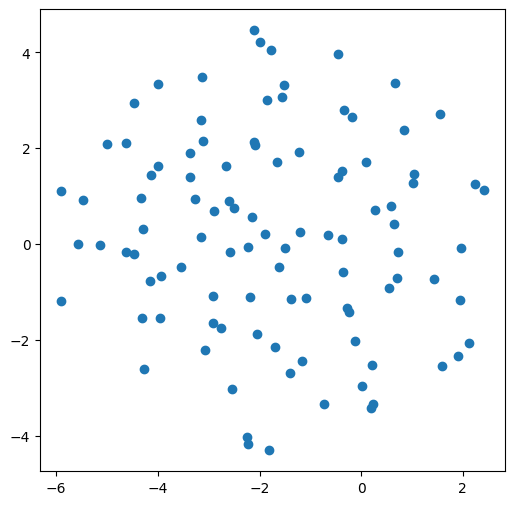

In [39]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6,6))

ax.scatter(df[0], df[1])